In [93]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')
words = stopwords.words("english")
stemmer = SnowballStemmer('english')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer

[nltk_data] Downloading package punkt to /Users/Student/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [94]:
stopwords_set = set(stopwords.words("english"))
df = pd.read_csv('1429_1.csv', keep_default_na=False, skip_blank_lines=False)
df = df.replace(np.nan, '', regex=True)




In [95]:
df['newComments'] = df[['reviews.text', 'reviews.title']].apply(lambda x: ' '.join(x), axis=1)
df['newComments'] = df['reviews.text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in stopwords_set]).lower())
TVec = TfidfVectorizer(sublinear_tf=True, min_df=6, stop_words='english')
ch2 = SelectPercentile(chi2, percentile=9.5)
X_text_processing = TVec.fit_transform(df['newComments'])

#df['reviews.rating'].astype(str).astype(int).astype(float)
#df['reviews.rating'].convert_objects(convert_numeric=True)
df['reviews.rating'] = pd.to_numeric(df['reviews.rating'],errors='coerce')

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(df[['reviews.rating']])
df['reviews.rating']=imp.transform(df[['reviews.rating']]).ravel()
'''
imputed_DF = pd.DataFrame(imp.fit_transform(df.loc[:, 14]))
imputed_DF.columns = df.columns
imputed_DF.index = df.index
'''
y_text_processing = df['reviews.rating'].astype(np.int64)

In [96]:
df['newComments']

0        this product far disappoint my children love u...
1           great beginn experienc person bought gift love
2        inexpens tablet use learn step nabi he thrill ...
3        i fire hd two week i love this tablet great va...
4        i bought grand daughter come visit i set user ...
5        this amazon fire inch tablet perfect size i pu...
6        great e read go nice light weight price point ...
7        i gave christma gift inlaw husband uncl they l...
8        great devic read book i like link borrow libra...
9                            i love order book read reader
10                         not easi elder user ceas ad pop
11       excel product easi use larg screen make watch ...
12       want father first tablet good valu he watch mo...
13       simpli everyth i need thank youand silk work w...
14                            got present love size screen
15       the kindl easiest use graphic screen crisp cle...
16       nice reader almost perfect want need good barga

In [97]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(binary=True, stop_words=stopwords.words('english'), lowercase=True, min_df=6,  max_features=5000)


In [98]:
#disc=df['newComments'].values.tolist()
#vect.fit(disc)
#columns_name=vect.get_feature_names()
#disc_vec=vect.fit_transform(disc)

In [99]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
#disc_vec_tfidf = tfidf_transformer.fit_transform(disc_vec)

In [100]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from numpy import array
label_encoder_y = LabelEncoder()
y_recommended = df['reviews.doRecommend']


#df['reviews.doRecommend'].eq('TRUE').mul(1)
df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: 1 if x == "TRUE" else x)
df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: 0 if x == "FALSE" else x)
df['reviews.doRecommend'] = df['reviews.doRecommend'].replace(np.nan, '', regex=True)
df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: 0 if x == '' else x)

#print(onehot_encoded)
y_keras = df['reviews.doRecommend']

X_train_kera, X_test_kera, y_train_kera, y_test_kera = train_test_split(df['newComments'], y_keras, test_size=0.3)
X_train_onehot = vect.fit_transform(X_train_kera)
X_train_onehot = tfidf_transformer.fit_transform(X_train_onehot)
X_test_onehot = vect.transform(X_test_kera)
X_test_onehot = tfidf_transformer.fit_transform(X_test_onehot)


In [101]:
#X_test_kera[0:,0].shape,y_test_kera.shape,X_train_kera.shape

In [102]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(X_train_onehot,y_train_kera)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [103]:
y_pred_LR=LR.predict(X_test_onehot)

In [104]:
from sklearn.metrics import mean_squared_error,r2_score
LR_RMSE = mean_squared_error(y_test_kera,y_pred_LR)

In [105]:
#from scipy.sparse import csr_matrix
#X_train_onehot = csr_matrix((X_train_onehot.data, X_train_onehot.indices, X_train_onehot.indptr), shape=(10399,1))
#y_test_kera = csr_matrix((y_test_kera.data, y_test_kera.indices, y_test_kera.indptr), shape=(10399,1))

Coefficients: 
 [ 0.14565084  0.05834698 -0.01327142 ...  0.0322035   0.14882379
 -0.3278991 ]
Mean squared error: 0.05
Variance score: 0.16


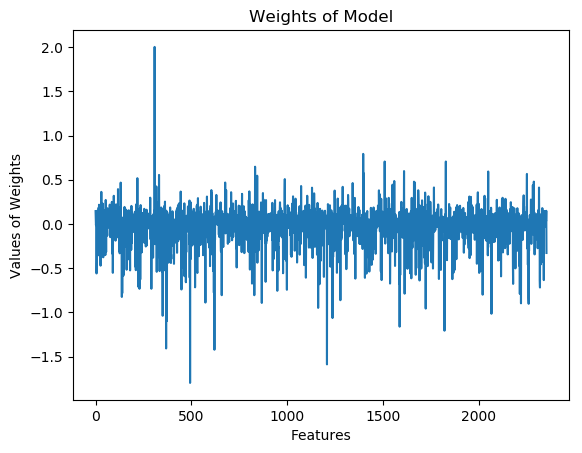

In [106]:
print('Coefficients: \n', LR.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test_kera, y_pred_LR))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test_kera, y_pred_LR))

plt.plot(LR.coef_)
plt.xlabel('Features')
plt.ylabel('Values of Weights')
plt.title('Weights of Model')
# Plot outputs
#plt.scatter(a[1:10400],y_pred,color='black')
#plt.scatter(X_train_onehot[:,0],y_test_kera,color='black')
#plt.plot(X_train_onehot[:,0], y_pred, color='blue')

#plt.xticks(())
#plt.yticks(())

plt.show()

In [107]:
LR_ypred_1 = []
LR_ypred_0 = []

In [108]:
for i in y_pred_LR:
    if i >0.9:
        LR_ypred_1.append(i)
    else:
        LR_ypred_0.append(i)

In [109]:
len(LR_ypred_0),len(LR_ypred_1)

(2456, 7943)

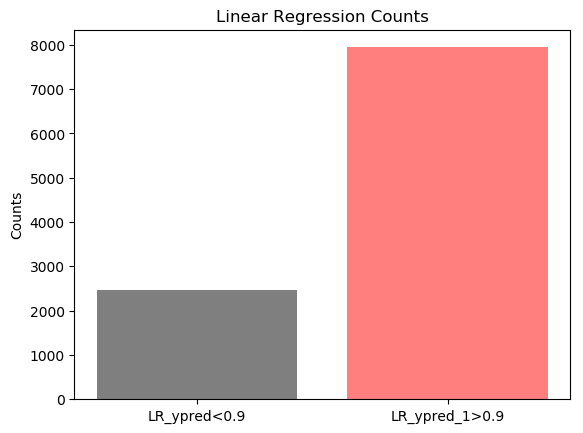

In [114]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('LR_ypred<0.9', 'LR_ypred_1>0.9')
y_pos = np.arange(len(objects))
performance = [len(LR_ypred_0),len(LR_ypred_1)]
 
plt.bar(y_pos, performance, align='center', alpha=0.5,color=('k', 'r'))
plt.xticks(y_pos, objects)
plt.ylabel('Counts')
plt.title('Linear Regression Counts')
 
plt.show()

In [115]:
from sklearn.linear_model import SGDClassifier
SGDClassifier = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
SGDClassifier.fit(X_train_onehot, y_train_kera)   

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [116]:
y_pred_SGD=SGDClassifier.predict(X_test_onehot)

In [117]:
SGD_RMSE = mean_squared_error(y_test_kera,y_pred_SGD)

In [118]:
SGD_ypred_1 = []
SGD_ypred_0 = []
for i in y_pred_SGD:
    if i ==1.0:
        SGD_ypred_1.append(i)
    else:
        SGD_ypred_0.append(i)

In [119]:
len(SGD_ypred_1),len(SGD_ypred_0)

(10364, 35)

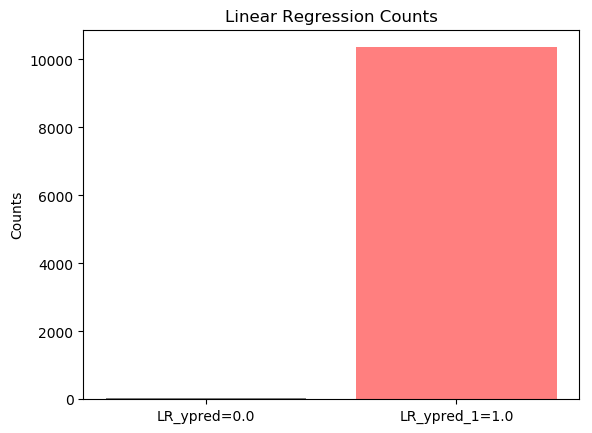

In [120]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('LR_ypred=0.0', 'LR_ypred_1=1.0')
y_pos = np.arange(len(objects))
performance = [len(SGD_ypred_0),len(SGD_ypred_1)]
 
plt.bar(y_pos, performance, align='center', alpha=0.5,color=('k', 'r'))
plt.xticks(y_pos, objects)
plt.ylabel('Counts')
plt.title('Linear Regression Counts')
 
plt.show()

In [121]:
from sklearn.ensemble import RandomForestRegressor

In [122]:
RandomForestRegressor = RandomForestRegressor(n_estimators=20)

In [123]:
RandomForestRegressor.fit(X_train_onehot, y_train_kera)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [124]:
y_pred_RF=RandomForestRegressor.predict(X_test_onehot)

In [125]:
RF_RMSE = mean_squared_error(y_test_kera,y_pred_RF)

In [126]:
RF_ypred_1 = []
RF_ypred_0 = []

In [127]:
for i in y_pred_RF:
    if i > 0.9 or i==0.9:
        RF_ypred_1.append(i)
    else:
        RF_ypred_0.append(i)

In [128]:
len(RF_ypred_0),len(RF_ypred_1)

(1324, 9075)

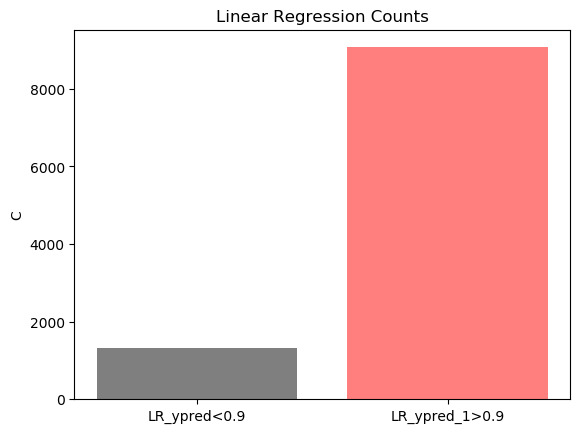

In [129]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('LR_ypred<0.9', 'LR_ypred_1>0.9')
y_pos = np.arange(len(objects))
performance = [len(RF_ypred_0),len(RF_ypred_1)]
 
plt.bar(y_pos, performance, align='center', alpha=0.5,color=('k', 'r'))
plt.xticks(y_pos, objects)
plt.ylabel('C')
plt.title('Linear Regression Counts')
 
plt.show()

In [130]:
from sklearn.linear_model import BayesianRidge

In [131]:
BayesianRidge = BayesianRidge()

In [132]:
BayesianRidge.fit(X_train_onehot.toarray(), y_train_kera)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [133]:
y_pred_BR=BayesianRidge.predict(X_test_onehot)

In [134]:
BR_RMSE = mean_squared_error(y_test_kera,y_pred_BR)

In [135]:
BR_ypred_1 = []
BR_ypred_0 = []

In [136]:
for i in y_pred_BR:
    if i > 0.5 or i==0.5:
        BR_ypred_1.append(i)
    else:
        BR_ypred_0.append(i)

In [137]:
len(BR_ypred_0),len(BR_ypred_1)

(85, 10314)

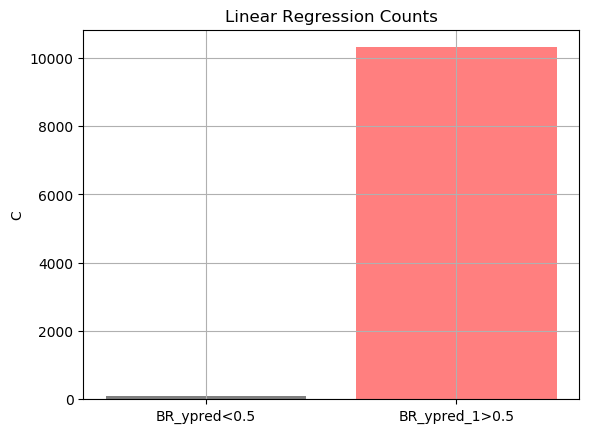

In [143]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('BR_ypred<0.5', 'BR_ypred_1>0.5')
y_pos = np.arange(len(objects))
performance = [len(BR_ypred_0),len(BR_ypred_1)]
 
plt.bar(y_pos, performance, align='center', alpha=0.5,color=('k', 'r'))
plt.grid()
plt.xticks(y_pos, objects)
plt.ylabel('C')
plt.title('Linear Regression Counts')
 
plt.show()

Text(0.5,1,'Comparison of Different Regression Algorithms on RMSE')

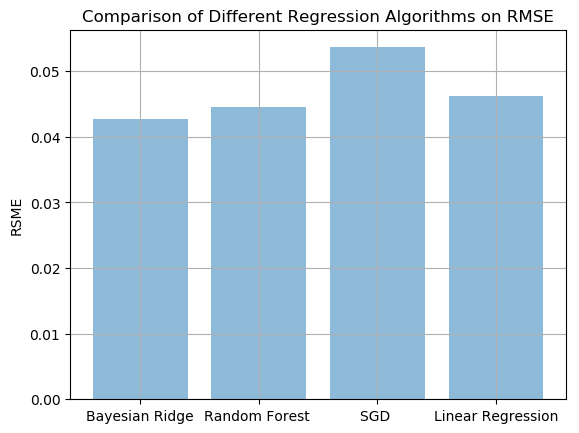

In [90]:
objects = ('Bayesian Ridge', 'Random Forest ', 'SGD ', 'Linear Regression')
y_pos = np.arange(len(objects))
performance = [BR_RMSE, RF_RMSE, SGD_RMSE, LR_RMSE]

plt.bar(y_pos, performance, align = 'center', alpha = 0.5)
plt.xticks(y_pos, objects)
plt.grid()
plt.ylabel('RSME')
plt.title('Comparison of Different Regression Algorithms on RMSE')